In [13]:
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=e45b92a23258137c577293354ce5145e5d5edfb17fc52ebf041f1e9071ac8aa0
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [15]:

import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf


from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


import matplotlib.pyplot as plt

In [17]:
N_STEPS = 7


LOOKUP_STEPS = [1, 2, 3]


STOCK = 'GOOGL'


date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [38]:

init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [39]:
init_df

,open,high,low,close,adjclose,volume,ticker
2021-04-05,107.357498,111.449501,107.260498,110.947998,110.947998,48510000,GOOGL
2021-04-06,110.545998,111.400002,110.089500,110.462997,110.462997,35240000,GOOGL
2021-04-07,110.654999,112.224998,110.654999,111.951500,111.951500,24134000,GOOGL
2021-04-08,113.199997,113.589500,112.150497,112.521500,112.521500,28664000,GOOGL
2021-04-09,112.272003,113.698502,111.862999,113.533501,113.533501,26146000,GOOGL
...,...,...,...,...,...,...,...
2024-04-08,152.779999,155.270004,152.610001,154.850006,154.850006,20702000,GOOGL
2024-04-09,156.089996,158.559998,155.190002,156.600006,156.600006,31113000,GOOGL
2024-04-10,156.210007,156.610001,154.679993,156.139999,156.139999,22838600,GOOGL
2024-04-11,156.910004,159.679993,156.460007,159.410004,159.410004,27166400,GOOGL


In [40]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [41]:
init_df

,close,date
2021-04-05,110.947998,2021-04-05
2021-04-06,110.462997,2021-04-06
2021-04-07,111.951500,2021-04-07
2021-04-08,112.521500,2021-04-08
2021-04-09,113.533501,2021-04-09
...,...,...
2024-04-08,154.850006,2024-04-08
2024-04-09,156.600006,2024-04-09
2024-04-10,156.139999,2024-04-10
2024-04-11,159.410004,2024-04-11


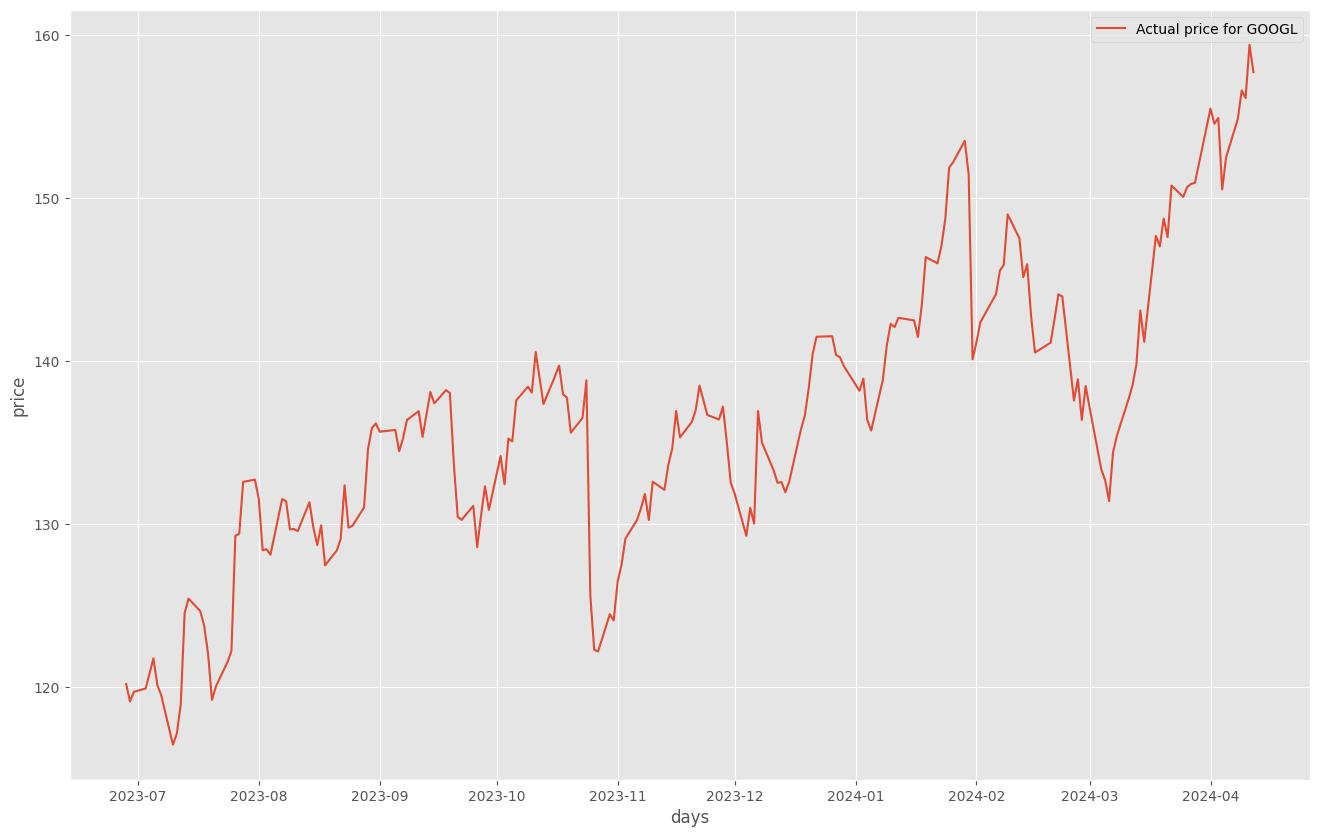

In [42]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [43]:
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [44]:
init_df


,close,date,scaled_close
2021-04-05,110.947998,2021-04-05,0.362174
2021-04-06,110.462997,2021-04-06,0.355791
2021-04-07,111.951500,2021-04-07,0.375382
2021-04-08,112.521500,2021-04-08,0.382884
2021-04-09,113.533501,2021-04-09,0.396203
...,...,...,...
2024-04-08,154.850006,2024-04-08,0.939984
2024-04-09,156.600006,2024-04-09,0.963017
2024-04-10,156.139999,2024-04-10,0.956962
2024-04-11,159.410004,2024-04-11,1.000000


In [45]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [46]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2021-04-05  110.947998 2021-04-05      0.362174  0.382884
 2021-04-06  110.462997 2021-04-06      0.355791  0.396203
 2021-04-07  111.951500 2021-04-07      0.375382  0.379060
 2021-04-08  112.521500 2021-04-08      0.382884  0.385516
 2021-04-09  113.533501 2021-04-09      0.396203  0.377277
 ...                ...        ...           ...       ...
 2024-04-03  154.919998 2024-04-03      0.940905  0.939984
 2024-04-04  150.529999 2024-04-04      0.883127  0.963017
 2024-04-05  152.500000 2024-04-05      0.909055  0.956962
 2024-04-08  154.850006 2024-04-08      0.939984  1.000000
 2024-04-09  156.600006 2024-04-09      0.963017  0.977889
 
 [759 rows x 4 columns],
 array([[0.94840753],
        [0.93616736],
        [0.94090545],
        [0.8831271 ],
        [0.909055  ],
        [0.93998426],
        [0.9630166 ],
        [0.9569623 ],
        [1.        ],
        [0.9778888 ]], dtype=float32),
 array([[[0.3621742106594425

In [47]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [48]:

predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 6s 15ms/step - loss: 0.0213
Epoch 2/80
95/95 [==============================] - 2s 16ms/step - loss: 0.0059
Epoch 3/80
95/95 [==============================] - 1s 12ms/step - loss: 0.0048
Epoch 4/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0047
Epoch 5/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 6/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0043
Epoch 7/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0038
Epoch 8/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0035
Epoch 9/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0037
Epoch 10/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0035
Epoch 11/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0030
Epoch 12/80
95/95 [==============================] - 1s 13ms/step - loss: 0.0031
Epoch 13/80
95/95 [==================

In [49]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

GOOGL prediction for upcoming 3 days (156.41$, 152.59$, 158.95$)


In [50]:

copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 6ms/step


In [51]:
copy_df

,close,date,scaled_close,predicted_close
2021-04-05,110.947998,2021-04-05,0.362174,114.137497
2021-04-06,110.462997,2021-04-06,0.355791,114.487999
2021-04-07,111.951500,2021-04-07,0.375382,113.950500
2021-04-08,112.521500,2021-04-08,0.382884,113.917503
2021-04-09,113.533501,2021-04-09,0.396203,112.625999
...,...,...,...,...
2024-04-08,154.850006,2024-04-08,0.939984,155.536774
2024-04-09,156.600006,2024-04-09,0.963017,157.063690
2024-04-10,156.139999,2024-04-10,0.956962,156.139999
2024-04-11,159.410004,2024-04-11,1.000000,159.410004


In [52]:

date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

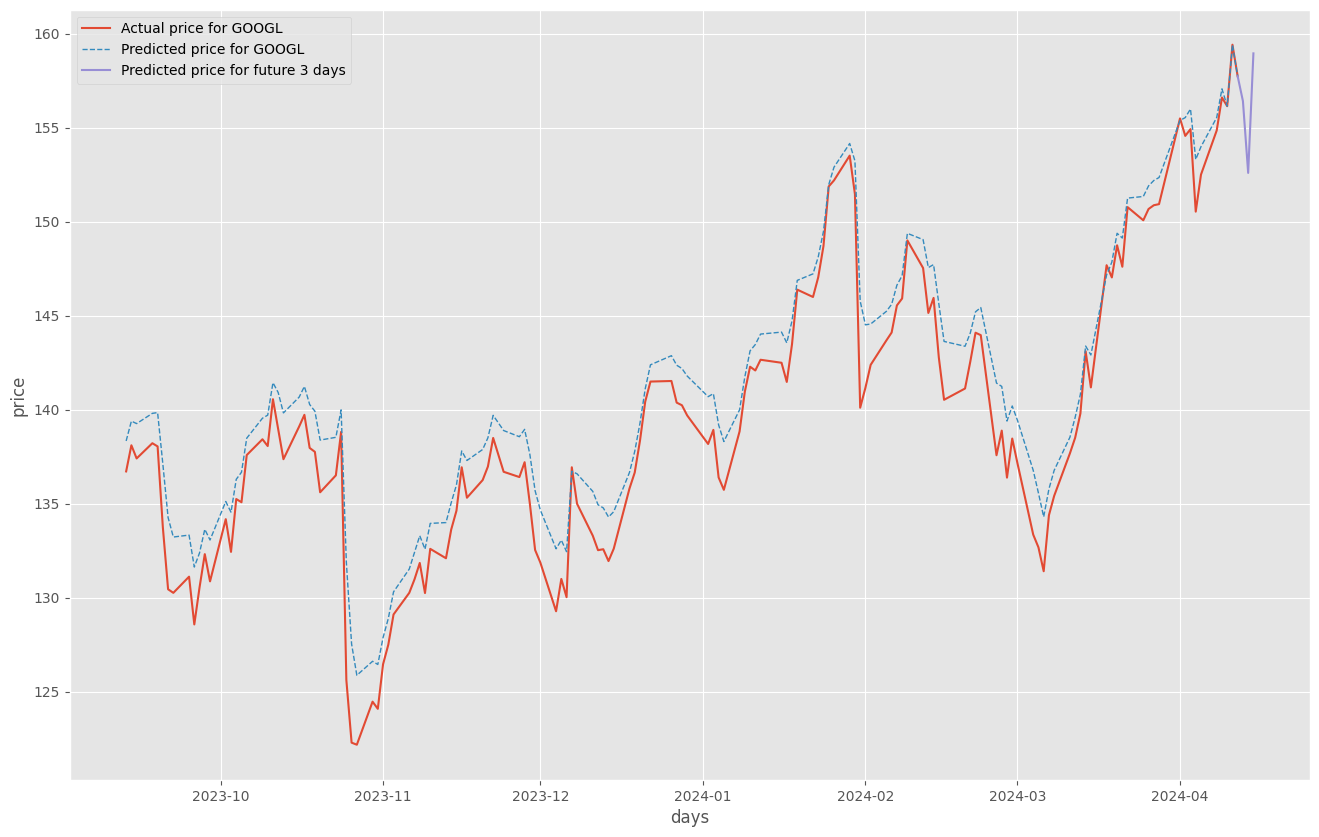

In [53]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()